In [2]:
from scipy.special import roots_jacobi, eval_jacobi
import numpy as np
import scipy
import math

In [226]:
import matplotlib.pyplot as plt

### Set points for the interpolation:

In [234]:
# Function will receive variable npts:
def return_points(npts, return_type):
    
    if return_type == 'GLL':
        p_order = npts - 1
        xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes.  Need to add -1 and 1
        return(np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1)))
    elif return_type == 'ES':
        dx = 2 / (npts - 1)
        return(np.array([-1 + (dx * value) for value in np.arange(npts)]))
    else:
        return('return_type not included in function :(')

In [291]:
# Return values for test function (x^3 or sin(x))
# Note: The Vandermonde matrix does not know about test func values; D matrix multiplies the test func values
def test_func1(domain):
    return(np.array(domain ** 3))

def test_func2(domain):
    return(np.sin(domain))

### Compute basis matrix for interpolant:

In [37]:
# Note: For nodes far from the origin or a high degree polynomial, the condition number of the matrix can be very large
# Generally avoid using monomial basis when q > 5 or poorly scaled nodes - Jiao, Lecture 15, AMS 527

In [46]:
# To create Legendre polynomials of degree k, use the following: np.polynomial.legendre.Legendre.basis(k, [-1, 1])
def legendre_poly_value(npts_values): # return values for the nth polynomial
    P = np.polynomial.legendre.Legendre.basis(len(npts_values) - 1, [-1, 1])
    return(P(npts_values))

In [55]:
# Function will receive inputs from return_points()
def vandermonde(npts_values, return_type):
    # For the monomial basis: 
    if return_type == 'Monomial':
        return(np.vander(npts_values, increasing = True))
    elif return_type == 'Legendre':
        return(np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1))

In [56]:
vandermonde(return_points(5, 'GLL'), 'Legendre')

array([[ 1.        , -1.        ,  1.        , -1.        ,  1.        ],
       [ 1.        , -0.65465367,  0.14285714,  0.28056586, -0.42857143],
       [ 1.        ,  0.        , -0.5       , -0.        ,  0.375     ],
       [ 1.        ,  0.65465367,  0.14285714, -0.28056586, -0.42857143],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ]])

In [95]:
# Sanity check for legvander():
P_test = np.polynomial.legendre.Legendre.basis(1, [-1, 1])
P_test(return_points(4, 'GLL'))

array([-1.       , -0.4472136,  0.4472136,  1.       ])

### Compute basis matrix for interpolant derivative:

In [359]:
# This function is written for basis matrix of the derivative of Legendre polynomials: 
def Ld_vandermonde(npts_values): 
    
    v_matrix = np.polynomial.legendre.legvander(npts_values, len(npts_values)-1)
    d_v_matrix = np.zeros_like(v_matrix)

    for i in range(len(npts_values)):
        # Coefficients for the i-th Legendre polynomial (e.g., [0, 0, 1] for P_2)
        coeffs = np.zeros(len(npts_values))
        coeffs[i] = 1

        # Compute the derivative of the i-th Legendre polynomial
        deriv_coeffs = L.legder(coeffs, m=1) # m=1 for first derivative

        # Evaluate the derivative at the points x
        d_v_matrix[:, i] = L.legval(npts_values, deriv_coeffs)
        
    return(d_v_matrix)

In [169]:
np.polynomial.legendre.Legendre.basis(3, [-1, 1]).deriv(m = 1)

Legendre([1., 0., 5.], domain=[-1.,  1.], window=[-1.,  1.])

In [170]:
# This function is written for basis matrix of the derivative of monomial basis: 
def Md_vandermonde(npts_values):
    
    v_matrix = np.vander(npts_values, increasing = True)
    d_v_matrix = np.zeros_like(v_matrix)
    
    for i in range(len(npts_values) - 1):
        coeffs = np.zeros(len(npts_values))
        coeffs[i] = i + 1
        
        deriv_P = np.polynomial.polynomial.Polynomial(coeffs) 
        d_v_matrix[:, i + 1] = deriv_P(npts_values)
        
    return(d_v_matrix)

In [121]:
P = np.polynomial.polynomial.Polynomial(np.array([value + 1 for value in np.zeros(len(return_points(4, 'GLL')))]))
P.deriv(m = 1)

Polynomial([1., 2., 3.], domain=[-1.,  1.], window=[-1.,  1.])

In [174]:
Md_vandermonde(return_points(5, 'ES'))

array([[ 0.  ,  1.  , -2.  ,  3.  , -4.  ],
       [ 0.  ,  1.  , -1.  ,  0.75, -0.5 ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  1.  ,  0.75,  0.5 ],
       [ 0.  ,  1.  ,  2.  ,  3.  ,  4.  ]])

### Compute the derivative matrix from basis matrices:

In [296]:
# This function returns V2 * V1 ^ -1 
def return_D(V1, V2):
    return(np.matmul(V2, np.linalg.inv(V1)))

In [297]:
def d_values(D, test_array):
    return(np.matmul(D, test_array.transpose()))

In [171]:
D = return_D(vandermonde(return_points(5, 'GLL'), 'Legendre'), Ld_vandermonde(return_points(5, 'GLL')))
np.matmul(D, np.array([return_points(5, 'GLL') ** 3]).transpose())

array([[3.        ],
       [1.28571429],
       [0.        ],
       [1.28571429],
       [3.        ]])

In [109]:
3 * np.array([return_points(5, 'GLL') ** 2])

array([[3.        , 1.28571429, 0.        , 1.28571429, 3.        ]])

### Fine grid basis matrices:

In [183]:
# Note: the fine Vandermonde matrices use equally spaced points

In [217]:
def V_finegrid(V1, num_pts, return_type):
    
    dx = 2 / (num_pts)
    npts = np.arange(-1, 1 + dx, dx)
    
    v_finegrid = np.zeros([len(npts), V1.shape[1]])analytic integrals of the basis functions 
    
    for i in range(V1.shape[1]):
        
        coeffs = np.zeros(V1.shape[1])
        coeffs[i] = 1
        
        if return_type == 'Legendre':
            L = np.polynomial.legendre.Legendre(coeffs)
            v_finegrid[:, i] = L(npts)
        elif return_type == 'Monomial':
            M = np.polynomial.polynomial.Polynomial(coeffs)
            v_finegrid[:, i] = M(npts)
            
    return(v_finegrid)

### Quadrature Weights: The Method of Undetermined Coefficents

#### Choose weights so that the rule integrates the first n polynomials exactly

In [413]:
npts_values = return_points(4, 'GLL')

def quad_weights(npts_values):
    
    # Values in f_array result from exact integration:
    f_array = np.zeros(len(npts_values))
    f_array[0] = 2
    
    # Define basis matrix for Legendre polynomials: 
    V = np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1).transpose()
    
    return(np.matmul(np.linalg.inv(V), f_array.transpose()))

In [414]:
quad_weights(npts_values)

array([0.16666667, 0.83333333, 0.83333333, 0.16666667])

### Quick Plots:

#### a. Interpolants:

In [283]:
GLL_points = return_points(4, 'GLL')
ES_points = return_points(4, 'ES')

In [293]:
V1 = vandermonde(GLL_points, 'Monomial') 
coeffs = np.matmul(np.linalg.inv(V1), test_func2(GLL_points).transpose())

V1_FG = V_finegrid(V1, 50, 'Monomial')

M = np.polynomial.polynomial.Polynomial(coeffs.transpose())
M(GLL_points)

array([-0.84147098, -0.43245484,  0.43245484,  0.84147098])

Text(0.5, 1.0, 'Monomial Polynomials; GLL points')

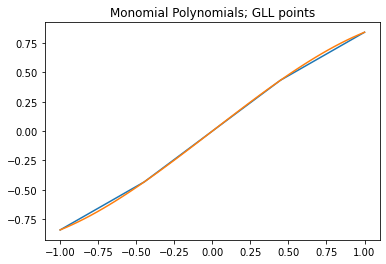

In [294]:
plt.plot(GLL_points, M(GLL_points))
plt.plot(np.arange(-1, 1 + (2/50), (2/50)), np.matmul(V1_FG, coeffs))
plt.title('Monomial Polynomials; GLL points')

#### b. Derivatives:

In [384]:
GLL_points = return_points(10, 'GLL')
V1 = vandermonde(GLL_points, 'Legendre') 
D = return_D(V1, Ld_vandermonde(GLL_points))


Text(0.5, 1.0, 'Legendre basis; 10 GLL points for d/dx sin(x)')

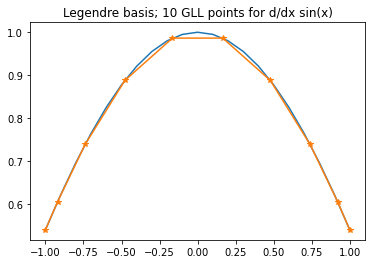

In [385]:
plt.plot(np.arange(-1, 1.1, 0.1), np.cos(np.arange(-1, 1.1, 0.1)))
plt.plot(GLL_points, d_values(D, test_func2(GLL_points)), marker = '*')
plt.title('Legendre basis; 10 GLL points for d/dx sin(x)')

### Property Check -> Integration by parts:

In [470]:
GLL_points = return_points(36, 'GLL')

V = vandermonde(GLL_points, 'Monomial')
D = return_D(V, Md_vandermonde(GLL_points))

# Only used to define the values of function at nodes:
P1 = np.polynomial.polynomial.Polynomial([1, 2, 3])
P2 = np.polynomial.polynomial.Polynomial([12, 14, 18])

b1 = P1(GLL_points)
b2 = P2(GLL_points)

In [471]:
RHS = (P1(1) * P2(1)) - (P1(-1) * P2(-1))
LHS = np.sum(d_values(D, b1) * b2 * quad_weights(GLL_points)) + np.sum(d_values(D, b2) * b1 * quad_weights(GLL_points))

In [472]:
RHS == LHS

False

In [473]:
RHS, LHS

(232.0, 232.0102261454478)